In [9]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchaudio.transforms as T
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import os
import time
import datetime


from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

import config

#from DL_Moco import DL_Moco as DL
from DL_Moco import DL_Moco_2 as DL

#clean cuda cache
torch.cuda.empty_cache()

In [10]:

n_fft = 2048
hop_length = 512
n_mels = 128

def calculate_mel_spec_size(sample_rate, desired_length_in_seconds, n_fft, hop_length, n_mels):
    number_of_samples = sample_rate * desired_length_in_seconds
    number_of_frames = (number_of_samples // hop_length) + 1  # Approximation
    return n_mels, number_of_frames

mel_spec_height, mel_spec_width = calculate_mel_spec_size(config.goal_sr_unlabeled, desired_length_in_seconds=config.desired_length_in_seconds, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

In [11]:
import torch
import torch.nn as nn
'''
class AudioEncoder(nn.Module):
    def __init__(self):
        super(AudioEncoder, self).__init__()
        # Define the layers of the CNN
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        # Calculate the size of the flattened features after the last convolutional layer
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 128, mel_spec_width)  # Use the size of your actual input
            dummy_output = self.forward_features(dummy_input)
            flattened_size = dummy_output.nelement()

        # Fully connected layer
        self.fc = nn.Linear(flattened_size, 128)

    def forward_features(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = torch.flatten(x, start_dim=1)  # Flatten the output for the fully connected layer
        x = self.fc(x)
        return x
'''

'\nclass AudioEncoder(nn.Module):\n    def __init__(self):\n        super(AudioEncoder, self).__init__()\n        # Define the layers of the CNN\n        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1)\n        self.bn1 = nn.BatchNorm2d(64)\n        self.relu = nn.ReLU()\n\n        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)\n        self.bn2 = nn.BatchNorm2d(128)\n\n        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1)\n        self.bn3 = nn.BatchNorm2d(256)\n\n        # Calculate the size of the flattened features after the last convolutional layer\n        with torch.no_grad():\n            dummy_input = torch.zeros(1, 3, 128, mel_spec_width)  # Use the size of your actual input\n            dummy_output = self.forward_features(dummy_input)\n            flattened_size = dummy_output.nelement()\n\n        # Fully connected layer\n        self.fc 

In [12]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class AudioEncoder(nn.Module):
    def __init__(self):
        super(AudioEncoder, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # ResNet layers
        self.layer1 = self._make_layer(ResidualBlock, 64, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(ResidualBlock, 128, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(ResidualBlock, 256, num_blocks=2, stride=2)
        self.layer4 = self._make_layer(ResidualBlock, 512, num_blocks=2, stride=2)

        # Calculate the size of the flattened features after the last layer
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 128, mel_spec_width)  # Adjust mel_spec_width as needed
            dummy_output = self.forward_features(dummy_input)
            flattened_size = dummy_output.nelement()

        # Fully connected layer
        self.fc = nn.Linear(flattened_size, 128)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward_features(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out

    def forward(self, x):
        x = self.forward_features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x


In [13]:
# Momentum Contrast (MoCo)
class MoCo(nn.Module):
    def __init__(self, base_encoder, dim=128, K=65536, m=0.999):
        super(MoCo, self).__init__()
        self.K = K - (K % config.batch_size)
        self.m = m
        self.dim = dim

        self.encoder_q = base_encoder()  # Query encoder
        self.encoder_k = base_encoder()  # Key encoder

        # Initialize the key encoder weights with the query encoder weights
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)  # initialize
            param_k.requires_grad = False  # not update by gradient

        # Create the queue
        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)
        self.queue_ptr = 0

    def forward(self, im_q, im_k):
        # Compute query features
        q = self.encoder_q(im_q)  # queries: NxC
        q = nn.functional.normalize(q, dim=1)

        # Compute key features
        with torch.no_grad():  # no gradient to keys
            self._momentum_update_key_encoder()  # update the key encoder
            k = self.encoder_k(im_k)  # keys: NxC
            k = nn.functional.normalize(k, dim=1)

        # Compute logits
        # Einstein sum is more intuitive
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])

        # logits: Nx(1+K)
        logits = torch.cat([l_pos, l_neg], dim=1)

        # Apply temperature
        logits /= config.temperature

        # Dequeue and enqueue
        self._dequeue_and_enqueue(k)

        return logits

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        batch_size = keys.shape[0]

        ptr = self.queue_ptr

        # Calculate how much space is left in the queue from the pointer position
        space_left = self.K - ptr

        # If the space left is less than the batch size, split the enqueue operation
        if space_left < batch_size:
            # Enqueue as much as possible in the remaining space
            self.queue[:, ptr:ptr + space_left] = keys.T[:, :space_left]
            # Enqueue the rest at the beginning of the queue
            self.queue[:, :batch_size - space_left] = keys.T[:, space_left:]
            self.queue_ptr = batch_size - space_left  # Update the pointer position
        else:
            # Regular enqueue operation
            self.queue[:, ptr:ptr + batch_size] = keys.T
            self.queue_ptr = (ptr + batch_size) % self.K  # Update the pointer position

In [14]:

moco = MoCo(AudioEncoder)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
moco.to(device)

# Rest of your setup (optimizer, loss function)
#optimizer = torch.optim.Adam(moco.parameters(), lr=0.001)
optimizer = torch.optim.SGD(moco.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
contrastive_loss = nn.CrossEntropyLoss()

# Training loop
num_epochs = 30
train_loader, test_loader = DL.create_generators()



Number of files:  38779
Number of files:  5539


In [15]:


for epoch in range(num_epochs):
    train_losses = []
    # Wrap the train_loader with tqdm for a progress bar
    train_loader_with_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch_idx, (data1, data2) in enumerate(train_loader_with_progress):
        # Ensure data is on the correct device
        data1, data2 = data1.to(device), data2.to(device)

        # Forward pass through MoCo with both data views
        output = moco(data1, data2)

        # Compute loss and perform optimization
        labels = torch.arange(data1.size(0)).to(device)
        loss = contrastive_loss(output, labels)
        train_losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        # Update the progress bar with the current loss
        train_loader_with_progress.set_postfix(loss=loss.item())

    #print average loss
    print("Average loss: ", np.mean(train_losses))

#save full model
torch.save(moco, './results/res_moco/moco.pth')

Epoch 1/30:   7%|▋         | 22/303 [00:33<07:05,  1.51s/it, loss=13]  


KeyboardInterrupt: 

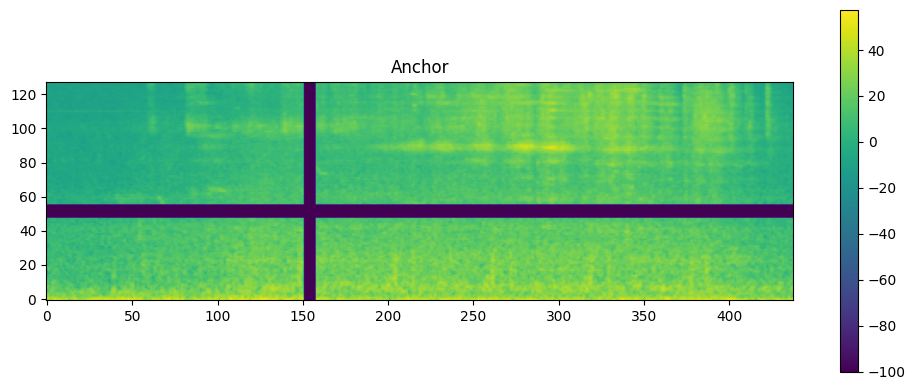

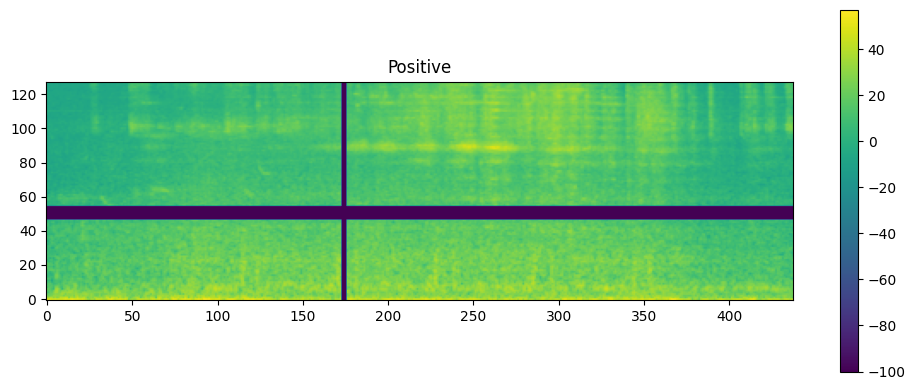

In [ ]:
#plot element from train_loader
data1, data2 = next(iter(train_loader))

plt.figure(figsize=(10, 4))
plt.imshow(data1[0].cpu().numpy()[0], origin='lower')
plt.colorbar()
plt.title('Anchor')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.imshow(data2[0].cpu().numpy()[0], origin='lower')
plt.colorbar()
plt.title('Positive')
plt.tight_layout()
plt.show()

